In [ ]:
#conda install pytorch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 pytorch-cuda=11.7 -c pytorch -c nvidia
#pip/conda install accelerate
pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117

In [9]:
pip install bitsandbytes -qq

Note: you may need to restart the kernel to use updated packages.


In [1]:
#from FrsECM.examples.community.semantic_image_synthesis.src.models import AutoencoderKL, AutoencoderSIS, UNet2DSISModel
#!pip install torch==1.13.1 -qq
import os
import sys
sys.path.insert(0, "/home/m112040012/vscode/LDM/diffuser_VQmodel/src")
sys.path.insert(1, '/home/m112040012/.conda/envs/NT2C/lib/python3.9/site-packages')

print(sys.path)
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice
import torch
import torch.nn as nn
import torch.utils.checkpoint
print(torch.__version__)#1.13.1+cu117

import torch

# 檢查CUDA是否可用
if torch.cuda.is_available():
    # 打印CUDA版本
    print(torch.version.cuda)#11.7
else:
    print("CUDA is not available.")

import torchvision
print(torchvision.__version__)#0.14.1+cu117

import diffusers
#print("diffusers 版本:", diffusers.__version__)
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
import requests
from PIL import Image
from io import BytesIO
from diffusers import StableDiffusionUpscalePipeline
from datasets import load_dataset
import requests
from PIL import Image
from io import BytesIO
from diffusers import LDMSuperResolutionPipeline
from torch.utils.data import random_split, DataLoader, Dataset, Subset
from diffusers import VQModel

#!nvidia-smi

['/home/m112040012/vscode/LDM/diffuser_VQmodel/src', '/home/m112040012/.conda/envs/NT2C/lib/python3.9/site-packages', '/usr/lib64/python2.7/site-packages/mpich-3.2', '/opt/anaconda3/envs/py39/lib/python39.zip', '/opt/anaconda3/envs/py39/lib/python3.9', '/opt/anaconda3/envs/py39/lib/python3.9/lib-dynload', '', '/home/m112040012/.local/lib/python3.9/site-packages', '/opt/anaconda3/envs/py39/lib/python3.9/site-packages']
1.13.1+cu117
11.7
0.14.1+cu117


2024-04-24 09:58:40.910640: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 09:58:41.898891: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:

!accelerate launch --num_processes=1 "/home/m112040012/vscode/LDM/diffuser_VQmodel/examples/vqgan/train_vqvae.py" \
--mixed_precision='no'\
--resolution=256 \
--num_train_epochs=100\
--validation_epochs=100\
--pretrained_model_name_or_path="stabilityai/stable-diffusion-2-1" \
--train_data_dir="/home/m112040012/vscode/data/10077/noise_patches_jpg/" \
--output_dir="/home/m112040012/vscode/vae_model/vqvae1/"\
--train_batch_size=4 \
--gradient_accumulation_steps=1 \
--checkpointing_steps=20000\
--scale_lr \
--checkpoints_total_limit=5\
--logging_dir="/home/m112040012/vscode/vae_model/vqvae1/log/"\
--lr_warmup_steps=500\
--learning_rate=1e-3\
--lr_scheduler="linear"

The following values were not passed to `accelerate launch` and had defaults used instead:
		More than one GPU was found, enabling multi-GPU training.
		If this was unintended please pass in `--num_processes=1`.
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
accelerate 位置: /home/m112040012/.conda/envs/NT2C/lib/python3.9/site-packages/accelerate/__init__.py
^C
Traceback (most recent call last):
  File "/home/m112040012/vscode/LDM/diffuser_VQmodel/examples/vqgan/train_vqvae.py", line 37, in <module>
    import diffusers
  File "/home/m112040012/vscode/LDM/diffuser_VQmodel/src/diffusers/__init__.py", line 5, in <module>
    from .utils import (
  File "/home/m112040012/vscode/LDM/diffuser_VQmodel/src/diffusers/utils/__init__.py", line 21, in <module>
    from .constants import (
  File "/home

In [17]:
!CUDA_VISIBLE_DEVICES=1,2,3 accelerate launch --num_processes=3 --num_machines=1 \
/home/m112040012/vscode/LDM/diffuser_VQmodel/examples/vqgan/train_vqgan.py \
--mixed_precision='no' \
--resolution=256 \
--num_train_epochs=60 \
--pretrained_model_name_or_path="stabilityai/stable-diffusion-2-1" \
--train_data_dir="/home/m112040012/vscode/data/10077/noise_patches_jpg/" \
--output_dir="/home/m112040012/vscode/vae_model/vqvae3/" \
--train_batch_size=4 \
--gradient_accumulation_steps=1 \
--checkpointing_steps=2000000 \
--scale_lr \
--checkpoints_total_limit=2 \
--logging_dir="/home/m112040012/vscode/vae_model/vqvae3/log/" \
--lr_warmup_steps=700 \
--discr_learning_rate=1e-3 \
--learning_rate=1e-3 \
# --use_8bit_adam \
# --allow_tf32 \
--discr_lr_scheduler="linear" \
--lr_scheduler="linear" \

The following values were not passed to `accelerate launch` and had defaults used instead:
		More than one GPU was found, enabling multi-GPU training.
		If this was unintended please pass in `--num_processes=1`.
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
accelerate 位置: /home/m112040012/.conda/envs/NT2C/lib/python3.9/site-packages/accelerate/__init__.py
accelerate 位置: /home/m112040012/.conda/envs/NT2C/lib/python3.9/site-packages/accelerate/__init__.py
accelerate 位置: /home/m112040012/.conda/envs/NT2C/lib/python3.9/site-packages/accelerate/__init__.py
diffusers 位置: /home/m112040012/vscode/LDM/diffuser_VQmodel/src/diffusers/__init__.py
['/home/m112040012/vscode/LDM/diffuser_VQmodel/src', '/home/m112040012/vscode/LDM/diffuser_VQmodel/examples/vqgan', '/usr/lib64/python2.7/site-packages/mpich-3.2', '/home/m112040012/.conda/envs/NT2C/l

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Steps:  45%|██████████▎            | 111553/249480 [8:28:14<11:17:54,  3.39it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Steps:  68%|███████████████▌       | 168896/249480 [12:49:28<5:37:20,  3.98it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Steps:  69%|███████████████▉       | 172777/249480 [13:07:09<6:16:19,  3.40it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Steps: 100%|█████████████████████████| 249480/249480 [18:56:32<00:00,  3.66it/s]


In [2]:
from dataclasses import dataclass
from torchvision import transforms
import torch
from itertools import islice
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami
from tqdm.auto import tqdm
from pathlib import Path
import os
from diffusers.optimization import get_cosine_schedule_with_warmup
import torch.nn.functional as F
from diffusers import LDMPipeline
from diffusers import DDIMScheduler
import torch.nn as nn

@dataclass
class TrainingConfig:
    image_size = 256  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 70
    gradient_accumulation_steps = 1
    learning_rate = 1e-3
    lr_warmup_steps = 500
    save_image_epochs = 100
    save_model_epochs = 300
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "/home/m112040012/vscode/vae_model/vqvae_unet/"  # the model namy locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False  
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0
    train_data_dir="/home/m112040012/vscode/data/10077/noise_patches_jpg/"
    
config = TrainingConfig()

In [3]:
dataset = load_dataset("imagefolder", data_dir=config.train_data_dir\
                       , split="train")
dataset

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.5], [0.5]),
    ]
)
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]] #.convert("L")
    return {"images": images}


dataset.set_transform(transform)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)
train_dataloader

Resolving data files:   0%|          | 0/16630 [00:00<?, ?it/s]

diffusers 位置: /home/m112040012/vscode/LDM/diffuser_VQmodel/src/diffusers/__init__.py
torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 32, 32])
torch.Size([16, 3, 256, 256])
(256, 256)
(256, 256)


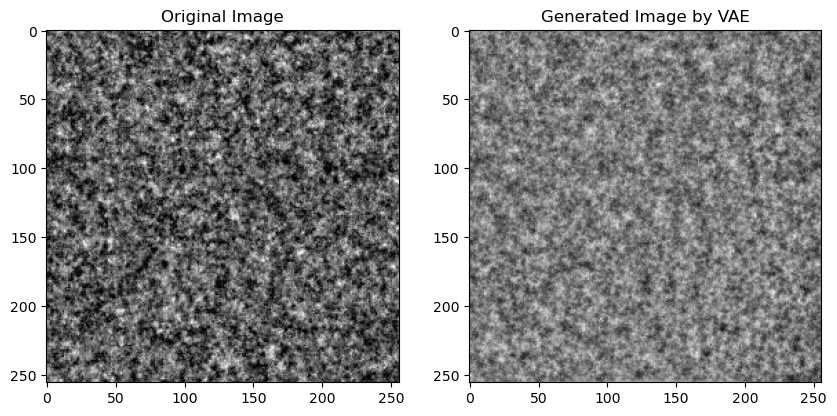

In [4]:
import sys
#sys.path.append("/home/m112040012/vscode/LDM/diffuser_VQmodel/src/diffusers")
sys.path.insert(0, "/home/m112040012/vscode/LDM/diffuser_VQmodel/src")
#print(sys.path)
import diffusers
print("diffusers 位置:", diffusers.__file__)
from diffusers.models.vq_model import VQModel
weight_dtype = torch.float32
#vae = AutoencoderKL.from_pretrained("/home/m112040012/vscode/wgan/LDM/vae/")#, low_cpu_mem_usage=False, ignore_mismatched_sizes=True)
vae=VQModel.from_pretrained("/home/m112040012/vscode/vae_model/vqvae2/") 
vae.eval()
a=2
for step, batch in enumerate(islice(train_dataloader, 1)): #islice(train_dataloader, 10)
            x = batch["images"].to(weight_dtype) #torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])
            print(x.shape)
            with torch.no_grad():
                posterior = vae.encode(x).latents   
                print(posterior.shape)
                pred = vae.decode(posterior).sample
                print(pred.shape)
# #                 latent = vae.forward(x, encode=True).latent_dist.mode() #torch.Size([16, 4, 32, 32])
# #                 pred = vae.forward(latent, decode=True).sample
                
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            
            img_original = x[a][0].numpy()
            # img_original = img_original - img_original.min()
            img_original = (img_original - img_original.min()) / (img_original.max() - img_original.min())
            print(img_original.shape)
            axs[0].imshow(img_original, cmap='gray')
            axs[0].set_title('Original Image')
            
            img = ((pred[a][0]+pred[a][1]+pred[a][2])/3).numpy()
            #img = pred[a][0].numpy()#.permute(1, 2, 0)       
            # img = img - img.min()
            img = (img - img.min()) / (img.max() - img.min())
            print(img.shape)
            axs[1].imshow(img, cmap='gray')
            axs[1].set_title('Generated Image by VAE')
           
            plt.show()

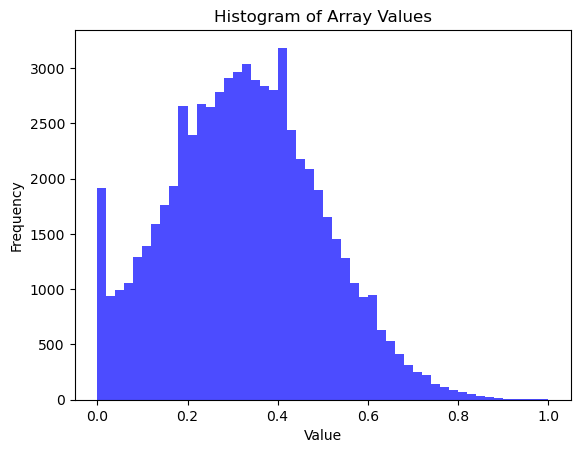

In [12]:
array_flat = img_original.flatten()

# 繪製直方圖
plt.hist(array_flat, bins=50, color='blue', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Array Values')
plt.show()

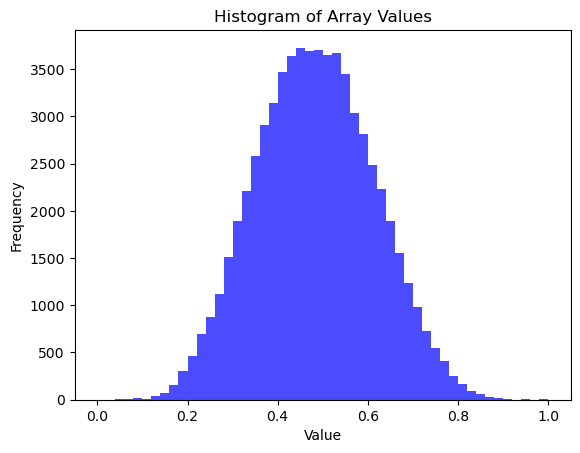

In [91]:
array_flat = img.flatten()

# 繪製直方圖
plt.hist(array_flat, bins=50, color='blue', alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Array Values')
plt.show()

In [10]:
from diffusers import UNet2DModel
from accelerate import notebook_launcher
import sys
sys.path.insert(0, "/home/m112040012/vscode/LDM/diffuser_VQmodel/src")
import diffusers
from diffusers.models.vq_model import VQModel
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
from diffusers.utils import check_min_version, is_wandb_available
print("diffusers 位置:", diffusers.__file__)

model = UNet2DModel(
    sample_size=32,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"
    
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    
    # Initialize accelerator and tensorboard logging
    vae = VQModel.from_pretrained("/home/m112040012/vscode/vae_model/vqvae2/") 
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
        cpu= False,
    )




    model, vae, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            model, vae, optimizer, train_dataloader, lr_scheduler
        )

    global_step = 0
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}") 
        for step, batch in enumerate(train_dataloader): #islice(train_dataloader, 10)
                x = batch["images"] #torch.Size([16, 3, 256, 256])
                with torch.no_grad():
                       #clean_images = vae.forward(x, encode=True).latent.mode() #torch.Size([16, 4, 32, 32])
                       clean_images = vae.encode(x).latents #torch.Size([16, 4, 32, 32])
                       #clean_images = clean_images.repeat(1, 4, 1, 1)
                # Sample noise to add to the images
                noise = torch.randn(clean_images.shape).to(clean_images.device)
                bs = clean_images.shape[0]
                #print(bs)
                # Sample a random timestep for each image
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
                ).long()

                # Add noise to the clean images according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
                #noisy_images = noisy_images.repeat(1, 4, 1, 1) ###改變通道
                with accelerator.accumulate(model):
                    # Predict the noise residual
                    noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                    loss = F.mse_loss(noise_pred, noise)
                    accelerator.backward(loss)

                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()
                    lr_scheduler.step()
                    optimizer.zero_grad()

                progress_bar.update(1)
                logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
                progress_bar.set_postfix(**logs)
                #accelerator.log(logs, step=global_step)
                global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

#             if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
#                 evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir)
                    
arg1 = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args=arg1, num_processes=1)

diffusers 位置: /home/m112040012/vscode/LDM/diffuser_VQmodel/src/diffusers/__init__.py


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Launching training on one GPU.


  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

diffusers 位置: /home/m112040012/vscode/LDM/diffuser_VQmodel/src/diffusers/__init__.py


  0%|          | 0/50 [00:00<?, ?it/s]

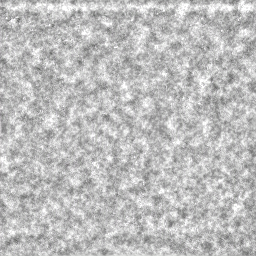

In [13]:
import sys
sys.path.insert(0, "/home/m112040012/vscode/LDM/diffuser_VQmodel/src")
import diffusers
from diffusers.models.vq_model import VQModel
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
from diffusers.utils import check_min_version, is_wandb_available
from diffusers import LDMPipeline
print("diffusers 位置:", diffusers.__file__)
model = UNet2DModel.from_pretrained("/home/m112040012/vscode/vae_model/vqvae_unet/unet/")
vae = VQModel.from_pretrained("/home/m112040012/vscode/vae_model/vqvae2/") 
scheduler=DDIMScheduler()
pipeline = LDMPipeline(vqvae=vae, unet=model, scheduler=scheduler)
pipeline = pipeline.to("cuda")
image = pipeline(batch_size=16).images[0]  #image = pipe(prompt, num_inference_steps=15, generator=generator).images[0]
image

In [86]:
a=pipeline(batch_size=50,num_inference_steps=100,output_type=1,return_dict=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [103]:
import cv2
name=0
file_path = "/home/m112040012/vscode/vae_model/image_gener/"
for i in range(100):
    img=pipeline(batch_size=50,num_inference_steps=100,return_dict=True,output_type=1)
    for j in range(50):
        img_gray = cv2.cvtColor(img.images[j], cv2.COLOR_RGB2GRAY)
        img_gray_uint8 = (img_gray * 255).astype(np.uint8)
        unique_filename = f"{file_path}{name}.jpg"
        cv2.imwrite(unique_filename, img_gray_uint8)
        name=name+1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]